In [2]:
# from google.colab import drive

# # Force remount to refresh credentials
# drive.mount('/content/drive', force_remount=True)

In [3]:
# !ls /content/drive/MyDrive/

In [4]:
# # Unzip training data
# !unzip /content/drive/MyDrive/Training.zip -d /content/train_data/

# # Unzip testing data
# !unzip /content/drive/MyDrive/Test.zip -d /content/test_data/

In [ ]:
# !ls /content/train_data/Training/
# !ls /content/test_data/Test/

Fire  No_Fire
Fire  No_Fire


In [ ]:
import os
import zipfile
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [ ]:
# Paths to your zip files
training_zip_path = 'Training.zip'   # <-- Adjust if your zip is in a different folder
test_zip_path = 'Test.zip'

In [ ]:
# Unzip training data
with zipfile.ZipFile(training_zip_path, 'r') as zip_ref:
    zip_ref.extractall('train_data')  # It will unzip to 'train_data' folder

In [ ]:
# Unzip testing data
with zipfile.ZipFile(test_zip_path, 'r') as zip_ref:
    zip_ref.extractall('test_data')   # It will unzip to 'test_data' folder

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

In [ ]:
# Set Paths for Fire and No Fire folders
train_fire_path = 'train_data/Training/Fire'
train_nonfire_path = 'train_data/Training/No_Fire'
test_fire_path = 'test_data/Test/Fire'
test_nonfire_path = 'test_data/Test/No_Fire'

In [16]:
def show_random_images(folder_path, title, num_images=5):
    images = os.listdir(folder_path)
    random_images = random.sample(images, num_images)

    plt.figure(figsize=(15,5))
    for i, img_name in enumerate(random_images):
        img_path = os.path.join(folder_path, img_name)
        img = mpimg.imread(img_path)
        plt.subplot(1, num_images, i+1)
        plt.imshow(img)
        plt.title(f'{title} {i+1}')
        plt.axis('off')
    plt.show()

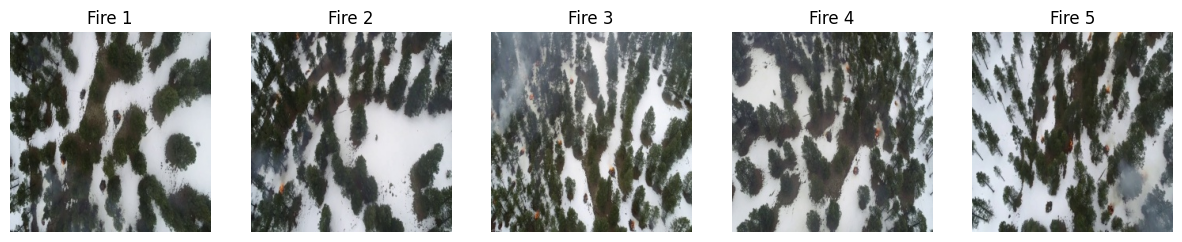

In [17]:
# Show 5 training fire images
show_random_images(train_fire_path, 'Fire')

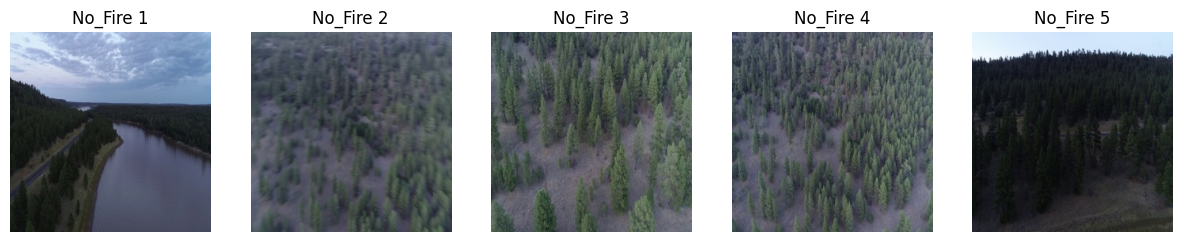

In [18]:
# Show 5 training nonfire images
show_random_images(train_nonfire_path, 'No_Fire')

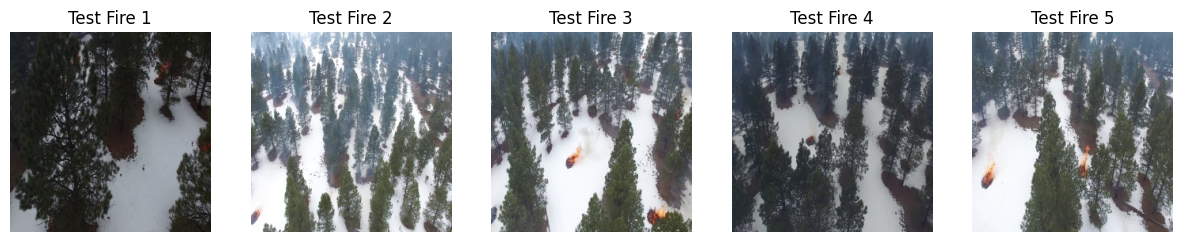

In [19]:
# Show 5 testing fire images
show_random_images(test_fire_path, 'Test Fire')

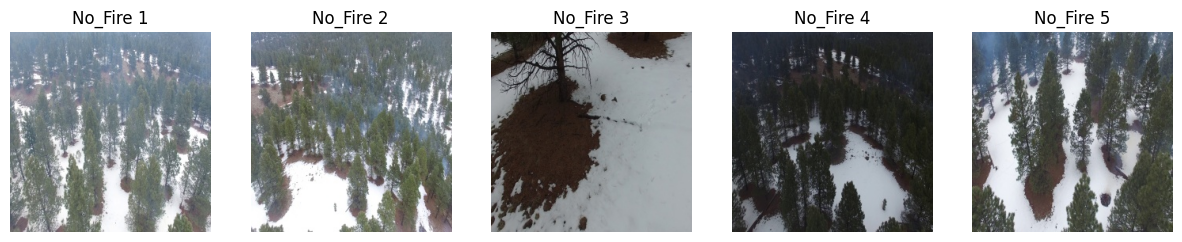

In [20]:
# Show 5 testing nonfire images
show_random_images(test_nonfire_path, 'No_Fire')

In [21]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# For training - better augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=35,            # more random rotation
    width_shift_range=0.3,        # more horizontal shift
    height_shift_range=0.3,       # more vertical shift
    shear_range=0.3,              # add shear transformation
    zoom_range=0.4,               # more zoom
    brightness_range=[0.6, 1.4],  # random brightness
    horizontal_flip=True,
    fill_mode='nearest'           # fill missing pixels after transforms
)

# For testing - still only rescale
test_datagen = ImageDataGenerator(
    rescale=1./255
)

In [1]:
# Data Generators
train_generator = train_datagen.flow_from_directory(
    'train_data/Training/',
    target_size=(254, 254),
    batch_size=64,
    class_mode='binary',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    'test_data/Test/',
    target_size=(254, 254),
    batch_size=64,
    class_mode='binary',
    shuffle=False
)

NameError: name 'train_datagen' is not defined

In [23]:
print(train_generator.class_indices)

{'Fire': 0, 'No_Fire': 1}


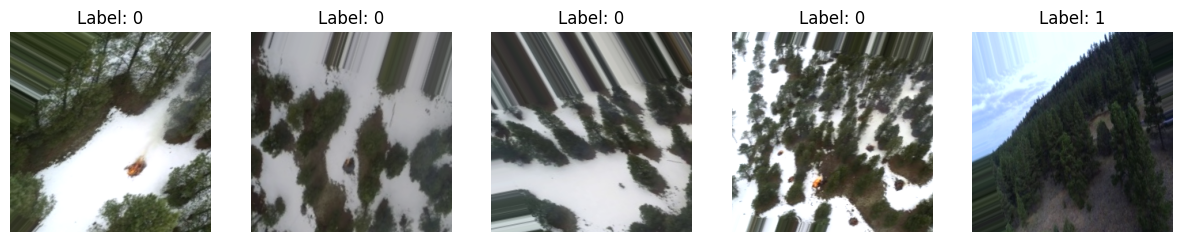

In [24]:
import matplotlib.pyplot as plt

# Get one batch from train_generator
images, labels = next(train_generator)

# Plot 5 images
plt.figure(figsize=(15,5))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(images[i])
    plt.title(f"Label: {int(labels[i])}")  # 0 or 1
    plt.axis('off')
plt.show()

In [25]:
# Build the Model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [26]:
from tensorflow.keras.applications import EfficientNetB0

# Load EfficientNet
efficientnet_base = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(254, 254, 3))

# Unfreeze more layers
efficientnet_base.trainable = True
for layer in efficientnet_base.layers[:100]:  # Freeze only first 100 layers
    layer.trainable = False

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [27]:
from tensorflow.keras.layers import Dropout

efficientnet_model = Sequential([
    efficientnet_base,
    GlobalAveragePooling2D(),
    Dropout(0.4),  # Drop 40% neurons randomly
    Dense(1, activation='sigmoid')
])


In [28]:
efficientnet_model.compile(optimizer=Adam(learning_rate=0.00001),
                            loss='binary_crossentropy',
                            metrics=['accuracy'])

In [29]:
# Callbacks
efficientnet_checkpoint = ModelCheckpoint('best_efficientnet_model.h5',
                                           save_best_only=True,
                                           save_weights_only=False,
                                           monitor='val_loss',
                                           mode='min',
                                           verbose=1)

efficientnet_earlystopping = EarlyStopping(monitor='val_loss',
                                           patience=5 ,   # patience 10 because training longer
                                           restore_best_weights=True,
                                           verbose=1)

In [30]:
# Train EfficientNet for more epochs
history_efficientnet = efficientnet_model.fit(
    train_generator,
    epochs=20,   # more epochs
    validation_data=test_generator,
    callbacks=[efficientnet_checkpoint, efficientnet_earlystopping],
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
616/616 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8247 - loss: 0.4107
Epoch 1: val_loss improved from inf to 0.78907, saving model to best_efficientnet_model.h5


616/616 ━━━━━━━━━━━━━━━━━━━━ 886s 1s/step - accuracy: 0.8247 - loss: 0.4105 - val_accuracy: 0.6046 - val_loss: 0.7891
Epoch 2/20
616/616 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9099 - loss: 0.2379
Epoch 2: val_loss did not improve from 0.78907
616/616 ━━━━━━━━━━━━━━━━━━━━ 791s 1s/step - accuracy: 0.9099 - loss: 0.2379 - val_accuracy: 0.6268 - val_loss: 0.8969
Epoch 3/20
616/616 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9255 - loss: 0.2025
Epoch 3: val_loss did not improve from 0.78907
616/616 ━━━━━━━━━━━━━━━━━━━━ 799s 1s/step - accuracy: 0.9255 - loss: 0.2025 - val_accuracy: 0.6353 - val_loss: 0.8994
Epoch 4/20
616/616 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9348 - loss: 0.1809
Epoch 4: val_loss did not improve from 0.78907
616/616 ━━━━━━━━━━━━━━━━━━━━ 792s 1s/step - accuracy: 0.9348 - loss: 0.1809 - val_accuracy: 0.6141 - val_loss: 1.1288
Epoch 5/20
616/616 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9420 - loss: 0.1631
Epoch 5: val_loss did not improve from 0.78907


In [31]:
# Evaluate EfficientNet
test_loss_efficientnet, test_accuracy_efficientnet = efficientnet_model.evaluate(test_generator, verbose=1)
print(f"Test Loss: {test_loss_efficientnet}")
print(f"Test Accuracy: {test_accuracy_efficientnet}")

135/135 ━━━━━━━━━━━━━━━━━━━━ 25s 186ms/step - accuracy: 0.8221 - loss: 0.4274
Test Loss: 0.7890727519989014
Test Accuracy: 0.6046187877655029


In [32]:
from tensorflow.keras.models import load_model

# First, load the best trained model (from .h5)
loaded_model = load_model('best_efficientnet_model.h5')

# Now save it in .keras format
loaded_model.save('best_efficientnet_model.keras')

print("Model loaded from .h5 and saved in .keras format successfully ✅")

Model loaded from .h5 and saved in .keras format successfully ✅


In [1]:
import zipfile

file = "best_mobilenet_model.keras"
print(zipfile.is_zipfile(file)) 

False
